#**Data Privacy: Computer Homework 01**


Sharif Univesity of  Technology - EE dept.

by Prof. Yassaee, Fall 2023

Contact *@danialayati* if you have any questions.

*Release Date:* 7 Azar 1402

*Soft Deadline:* 21 Azar 1402 - 23:55

*Hard Deadline:* 25 Azar 1402 - 23:55



---



# *Question 1*: In this question we want to demonstrate membership inference attacks on means by test statistics



First, tuneable simulation parameters:

In [33]:
import numpy as np
from scipy import stats
import math
np.random.seed(123)

## PARAMETERS
n_sims = 10000
n_samples = 10
k_att = 100

Then, define utility functions for simulating data and calculating the test statistics:


In [34]:
def synthesize(population_prob, n=1):
    x = np.random.binomial(n=1, p=population_prob, size=(n, len(population_prob)))
    return x


## TEST STATISTICS
def test_homer(alice, sample_mean, population_mean):
    test_statistic = sum(abs(alice - population_mean) - abs(alice - sample_mean))
    return test_statistic


def test_dwork(alice, sample_mean, population_mean):
    test_statistic = sum( (alice-population_mean) *  (sample_mean-population_mean) )
    return test_statistic


def null_distribution(fun, population_prob, population_mean, null_sims=1000, alpha=0.05):
    hold = []

    for i in range(null_sims):
        sample_mean = synthesize(population_prob, n=n_samples).mean(axis=0)
        null_alice = synthesize(population_prob)[0]
        hold.append(fun(null_alice, sample_mean, population_mean))

    null_dist_vals = np.sort(hold)[::-1]
    return {
        "nulldist": null_dist_vals,
        "critical_val": null_dist_vals[round(alpha * null_sims)]
    }

Create Simple graph function for showing the distribution, partitioned by critical value, then Simulate and graph a null distribution:

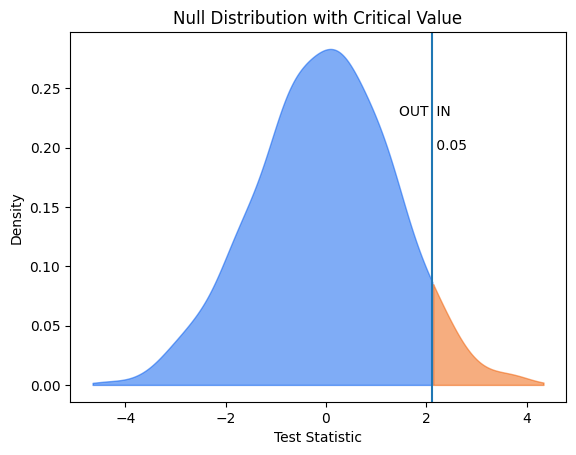

In [35]:
import matplotlib.pyplot as plt


def show_distribution(x, critical_value, title):

    kernel = stats.gaussian_kde(x)
    support = np.linspace(min(x) - kernel.factor, max(x) + kernel.factor, num=500)
    densities = kernel(support)

    flag = support < critical_value
    max_density = max(densities)

    plt.fill_between(support[flag], densities[flag], color='#005aef80')
    plt.fill_between(support[~flag], densities[~flag], color='#ef5c0080')
    plt.axvline(x=critical_value)
    plt.text(x=critical_value, y=0.8*max_density, s=" IN", horizontalalignment='left')
    plt.text(x=critical_value, y=0.8*max_density, s="OUT ", horizontalalignment='right')
    plt.text(x=critical_value, y=0.7*max_density, s=f' {(x > critical_value).mean():.2}', horizontalalignment='left')
    plt.title(title)
    plt.xlabel("Test Statistic")
    plt.ylabel("Density")
    plt.show()

population_prob = np.random.uniform(size=k_att)
population_mean = population_prob

output = null_distribution(test_homer, population_prob, population_mean)
testdist = output["nulldist"]
criticalValue = output["critical_val"]
show_distribution(testdist, criticalValue, title="Null Distribution with Critical Value")
plt.show()

Now create a complete simulation of attack. We are going to iterate across datasets, calculate the discrimination of the test statistic among observations in the private data and the null population.

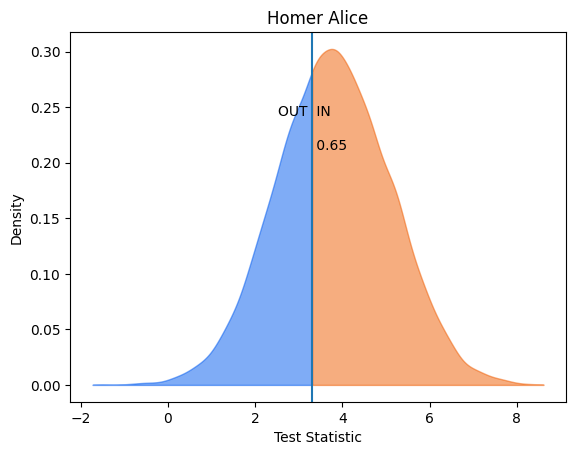

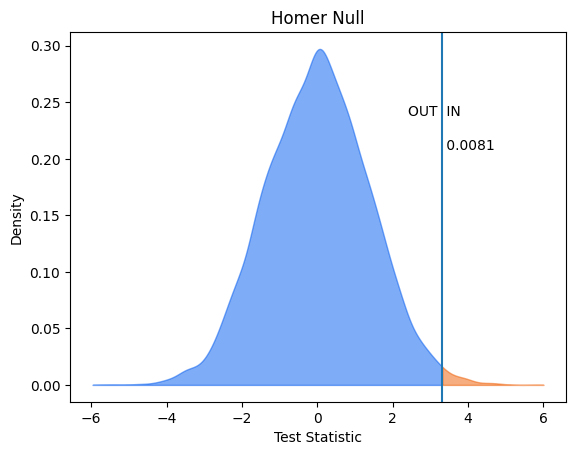

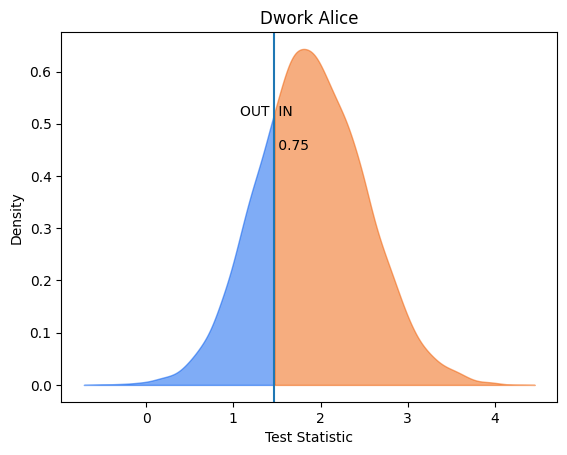

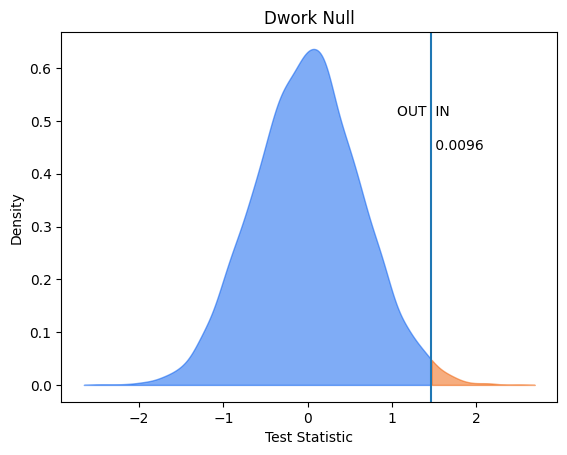

In [36]:
## SIMULATE

history = np.zeros(shape=(n_sims, 4))

alpha = 0.01
nullDist_Homer = null_distribution(test_homer, population_prob, population_mean, alpha=alpha)
nullDist_Dwork = null_distribution(test_dwork, population_prob, population_mean, alpha=alpha)

for i in range(n_sims):
    sample = synthesize(population_prob, n=n_samples)
    sample_mean = sample.mean(axis=0)
    alice = sample[0]
    null_alice = synthesize(population_prob, n=1)[0]

    history[i, :] = [

        test_homer(alice=alice, sample_mean=sample_mean, population_mean=population_mean),
        test_homer(alice=null_alice, sample_mean=sample_mean, population_mean=population_mean),

        test_dwork(alice=alice, sample_mean=sample_mean, population_mean=population_mean),
        test_dwork(alice=null_alice, sample_mean=sample_mean, population_mean=population_mean)
    ]

show_distribution(history[:, 0], critical_value=nullDist_Homer["critical_val"], title="Homer Alice")
show_distribution(history[:, 1], critical_value=nullDist_Homer["critical_val"], title="Homer Null")

show_distribution(history[:, 2], critical_value=nullDist_Dwork["critical_val"], title="Dwork Alice")
show_distribution(history[:, 3], critical_value=nullDist_Dwork["critical_val"], title="Dwork Null")




---



# *Question 2:* Now Let's bulid  Laplace Mechanism for Differential Privacy

First, construct the basic building blocks for a Laplace mechanism, a random sampler from the distribution, a clamp/clip/censor function, the function for the true mean, and then the DP release algorithm itself.

In [37]:
import numpy as np

def laplace(shift=0., scale=1., size=None):

    return np.random.laplace(loc=shift, scale=scale, size=size)


def clamp(x, bounds):

    return np.clip(x, *bounds)


def bounded_mean(x, bounds):

    return np.mean(clamp(x,bounds))


def release_dp_mean(x, bounds, epsilon):

    # privatize
    n = len(x)
    lower, upper = bounds
    sensitivity = (upper-lower)/n
    scale = sensitivity/epsilon

    sensitive_answer = bounded_mean(x, bounds)

    dp_mean = sensitive_answer + laplace(shift=0., scale=scale)
    return dp_mean


Read in the data.  We're going to use the PUMS dataset, and focus on the education variable, a 16 point scale:

In [38]:
import pandas as pd
data = pd.read_csv(
    "https://raw.githubusercontent.com/opendp/cs208/main/spring2022/data/FultonPUMS5full.csv")


n = len(data)
educ_bounds = (1., 16.)

educ = data['educ'].values.astype(float)
print(release_dp_mean(educ, bounds=educ_bounds, epsilon=1.))


10.608614115738709


Now that we have a mechanism available, let's try a new one, the histogram.  Histograms give counts of the number of observations within defined partitions of the variable domain.  Consider carefully the sensitivity for the histogram, which depends on which definition of neighbouring we are using. After that,  call your privacy-preserving histogram.

In [39]:
def release_histogram(x, epsilon, categories):
    sensitivity = 1
    scale = sensitivity/epsilon

    counts = dict(zip(*np.unique(x, return_counts=True)))

    sensitive_histogram = np.array([counts.get(cat, 0) for cat in categories])

    dp_histogram = sensitive_histogram + laplace(scale=scale, size=sensitive_histogram.shape)
    return dp_histogram


educ_categories = list(range(1, 17))
output = release_histogram(educ, epsilon=1., categories=educ_categories)

print(output)

[ 273.19122912  140.29404527  356.56534302  469.37529906  495.4698119
  756.45464928  893.96561021 1059.98217756 5147.06038921 1396.07750873
 3964.69125637 1153.36993322 6283.9792349  2268.48242013  795.49768221
  311.30200825]


Now we want to to simulate repeated draws from the Laplace mechanism to examine the utility it offers over the range of epsilon values and dataset sizes, for our education variable. We'll need a way to construct new datasets, given we only have one available.  The (nonparametric) bootstrap function lets us construct datasets even larger than our original source data if needed, by treating the sample data as if it is a population from which we can resample.

In [40]:
import math

def bootstrap(x, n):
    return np.random.choice(x, size=n)


n_sims = 1000

log_seq = np.linspace(start=math.log10(200), stop=math.log10(1500), num=15)
n_seq = (10**log_seq).astype(int)
print(n_seq)


log_seq = np.linspace(start=math.log10(1), stop=math.log10(0.1), num=5)
ep_seq = (10**log_seq *100).astype(int)/100
print(ep_seq)

agg_history = []

aggcount = 0

for i, n_sim in enumerate(n_seq):
    for j, epsilon_sim in enumerate(ep_seq):
        sq_error = 0

        for k in range(n_sims):
            bootdata = bootstrap(educ, n_sim)
            sensitive_mean = bounded_mean(x=bootdata, bounds=educ_bounds)
            dp_mean = release_dp_mean(x=bootdata, bounds=educ_bounds, epsilon=epsilon_sim)
            sq_error += (dp_mean - sensitive_mean) ** 2

        agg_history.append([
            n_sim,
            epsilon_sim,
            np.sqrt(sq_error/n_sims)  #RMSE
        ])

        aggcount += 1

agg_history = pd.DataFrame(agg_history, columns=["N", "epsilon", "error"])


[ 200  230  266  307  355  410  474  547  632  730  843  974 1124 1298
 1500]
[1.   0.56 0.31 0.17 0.1 ]


Now graph your resluts!

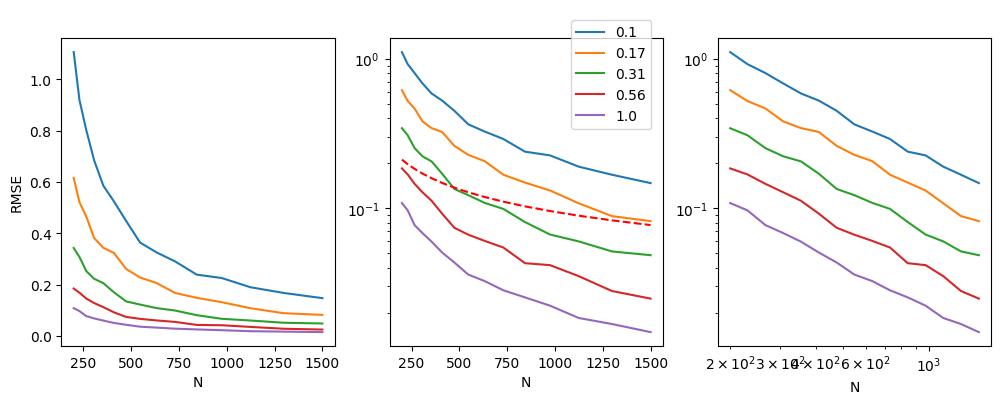

In [41]:

import matplotlib
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=3, figsize=(12,4))

axs[0].set_ylabel("RMSE")
axs[1].set_yscale("log")
axs[2].set_xscale("log")
axs[2].set_yscale("log")

for epsilon_sim, subhistory in agg_history.groupby("epsilon"):
    for ax in axs:
        subhistory.plot(x="N", y="error", label=epsilon_sim, ax=ax, legend=None)

se = np.std(educ) / np.sqrt(n_seq)
axs[1].plot(n_seq, se, linestyle='dashed', color="red")

_ = fig.legend(*axs[0].get_legend_handles_labels(), loc=(0.57, 0.68))




---



# *Question 3:* OPENDP

The OpenDP Project is a community effort to build trustworthy, open source software tools for analysis of private data. The core software of the OpenDP Project is the OpenDP Library.

The OpenDP Library is a modular collection of statistical algorithms that adhere to differential privacy. The library is based on a conceptual framework described in [A Programming Framework for OpenDP](https://projects.iq.harvard.edu/files/opendp/files/opendp_programming_framework_11may2020_1_01.pdf).

The OpenDP Library can be found on GitHub: https://github.com/opendp/opendp/

OpenDP represents computations with Transformations and Measurements. First, recall all you need from opendp, then create a measurement that simply addds laplace noise and like a function.

In [1]:
!pip install opendp==0.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.0/28.0 MB 7.7 MB/s eta 0:00:00
  Attempting uninstall: opendp
    Found existing installation: opendp 0.8.0
    Uninstalling opendp-0.8.0:
      Successfully uninstalled opendp-0.8.0


In [42]:
from opendp.meas import *
from opendp.trans import *
from opendp.typing import *
from opendp.mod import enable_features, Transformation, Measurement
enable_features("contrib", "floating-point")

scale = 0.5
base_laplace: Measurement = make_base_laplace(scale=scale)

base_laplace(arg=23.)

23.89726990600858

We can also chain transformations and measurements. You might already think of chaining as function composition. The reason why we call it "chaining," instead of "composition," is because composition has a special meaning in differential privacy. In the context of differential privacy, composition refers to the joint release of more than one measurement.

In [46]:
sized_bounded_mean: Transformation = make_sized_bounded_mean(size=26000, bounds=educ_bounds)

sized_bounded_mean(arg=educ)

dp_mean: Measurement = sized_bounded_mean >> base_laplace

dp_mean(arg=educ)



10.985018416008572

Now that we've shown how to build up computations and execute them, lets talk about distances.

Transformations and Measurements relate distances. There are three kinds of distances:

1. Dataset distances  
    (greatest distance between neighboring datasets)
1. Sensitivities  
    (greatest distance between queries on neighboring datasets)
1. Privacy budget    
    (greatest distance between the probability distributions)

The following shows how the `base_laplace` measurement relates a `sensitivity` to a privacy budget, `epsilon`.

In [17]:
# Check that when sensitivity is 0.15, the privacy usage is .30
base_laplace.check(d_in=.15, d_out=.30)

True

We can interpret this as: If the sensitivity is .15, then we could release the query answer with `laplace(scale=.5)` noise at a privacy expenditure of `.3 epsilon`. Equivalently, this data release is `.3 differentially private`, or `.3-DP`, where the privacy units are implicitly in terms of epsilon.

If we were to increase the sensitivity, the same relation would fail, and the release would not be `.3-DP`.

In [18]:
base_laplace.check(d_in=.16, d_out=.3)

False

As you might expect, the relation will also pass for any sensitivity that is smaller, or any privacy expenditure that is larger. And similarly, the `sized_bounded_mean` transformation relates a dataset distance `max_influence` to a `sensitivity`.

In [20]:
print(base_laplace.check(d_in=.15, d_out=.31))
print(base_laplace.check(d_in=.14, d_out=.30))
max_influence = 1 # the greatest number of records that an individual can influence
sized_bounded_mean.check(d_in=max_influence, d_out=.15)

True
True


True

Now relate distances on chained computations. The units for the input and output distances come from the constituent transformations and measurements.

For example, when we chain the `sized_bounded_mean` transformation and `base_laplace` measurement together, the input distance is a dataset distance, `max_influence`, and the output distance is measured in terms of a privacy budget, `epsilon`.

In [23]:
# Check that when neighboring datasets differ by at most one record, the privacy usage is .3
dp_mean.check(d_in=1, d_out=.3)

True

The `release_histogram` function behaves similarly to the `make_count_by_categories` function in OpenDP.

In [ ]:
help(make_count_by_categories)

In [21]:
# release a histogram with laplace noise
dp_histogram_laplace = (
    make_count_by_categories(categories=educ_categories, TOA=float, MO=L1Distance[float]) >>
    make_base_laplace(scale=1., D=VectorDomain[AllDomain[float]])
)
dp_histogram_laplace(educ.astype(np.int32))


[271.61241825413356,
 138.47060083070858,
 357.36605975022826,
 470.12420967836044,
 497.25948523469526,
 757.3531333163843,
 892.5399428373173,
 1060.5301362948424,
 5146.866077972135,
 1396.568857044129,
 3962.131193738204,
 1152.1810418694386,
 6283.799345712494,
 2268.7403870864905,
 795.2419647667947,
 307.17712313975113,
 0.9648351568479152]

In [22]:
# release a histogram with geometric noise
# release a histogram with geometric noise
dp_histogram_geometric = (
    make_count_by_categories(categories=educ_categories) >>
    make_base_geometric(scale=1., D=VectorDomain[AllDomain[int]])
)
dp_histogram_geometric(educ.astype(np.int32))

[271,
 141,
 357,
 469,
 497,
 755,
 894,
 1060,
 5145,
 1397,
 3964,
 1155,
 6282,
 2269,
 794,
 308,
 -1]



---



# *Question 4:* Gaussian Mechanism

Let's extend the basic building blocks to include a Gaussian mechanism and a random sampler from the Gaussian.

In [26]:
!pip install mock

In [28]:
import numpy as np
from mock import MagicMock
from mock import *


def gaussian(shift=0., scale=1., size=None):
    draws = np.random.normal(loc=shift, scale=scale, size=size)
    return draws


def release_dp_mean(x, bounds, epsilon, delta=1e-6, mechanism="laplace"):
    sensitive_mean = bounded_mean(x, bounds)

    n = len(x)
    lower, upper = bounds

    sensitivity = (upper - lower) / n

    if mechanism == "laplace":
        scale = sensitivity / epsilon
        dp_mean = sensitive_mean + laplace(scale=scale)
    elif mechanism == "gaussian":
        scale = (sensitivity / epsilon) * np.sqrt(2*np.log(2/delta))
        dp_mean = sensitive_mean + gaussian(scale=scale)
    else:
        raise ValueError(f"unrecognized mechanism: {mechanism}")

    return dp_mean



Read in the data. We are using the familiar PUMS dataset we are familiar with, and focusing on the education variable, a 16 point scale.

In [47]:
import pandas as pd
data = pd.read_csv(
    "https://raw.githubusercontent.com/opendp/cs208/main/spring2022/data/FultonPUMS5full.csv")


n = len(data)
educ_bounds = (1., 16.)
educ = data['educ'].values.astype(float)
print(release_dp_mean(educ, bounds=educ_bounds, epsilon=1.))

10.60556817033081


Now simulate repeated draws from both mechanisms to compare the utility they offer over a range of epsilon values and dataset sizes.  

In [30]:
n_sims = 1000

n_seq = np.logspace(start=np.log10(200), stop=np.log10(1500), num=15).astype(int)
print("N sequence      ", n_seq)

ep_seq = np.around(np.logspace(start=np.log10(1), stop=np.log10(0.1), num=5), decimals=2)
print("epsilon sequence", ep_seq)

my_delta = 1e-6

agg_history = []

aggcount = 0

for i, n_sim in enumerate(n_seq):
    for j, epsilon_sim in enumerate(ep_seq):
        sq_error_laplace = sq_error_gaussian = 0

        for k in range(n_sims):
            bootdata = bootstrap(educ, n_sim)
            sensitive_mean = bounded_mean(x=bootdata, bounds=educ_bounds)
            dp_mean_laplace = release_dp_mean(x=bootdata, bounds=educ_bounds, epsilon=epsilon_sim, mechanism="laplace")
            dp_mean_gaussian = release_dp_mean(x=bootdata, bounds=educ_bounds, epsilon=epsilon_sim, delta=my_delta, mechanism="gaussian")
            sq_error_laplace += (dp_mean_laplace - sensitive_mean) ** 2
            sq_error_gaussian += (dp_mean_gaussian - sensitive_mean) ** 2

        agg_history.append([
            n_sim,
            epsilon_sim,
            np.sqrt(sq_error_laplace/n_sims),   # RMSE Laplace
            np.sqrt(sq_error_gaussian/n_sims)   # RMSE Gaussian
        ])


agg_history = pd.DataFrame(agg_history, columns=["N", "epsilon", "laplace error", "gaussian error"])


N sequence       [ 200  230  266  307  355  410  474  547  632  730  843  974 1124 1298
 1500]
epsilon sequence [1.   0.56 0.32 0.18 0.1 ]


And Finally Graph your result:

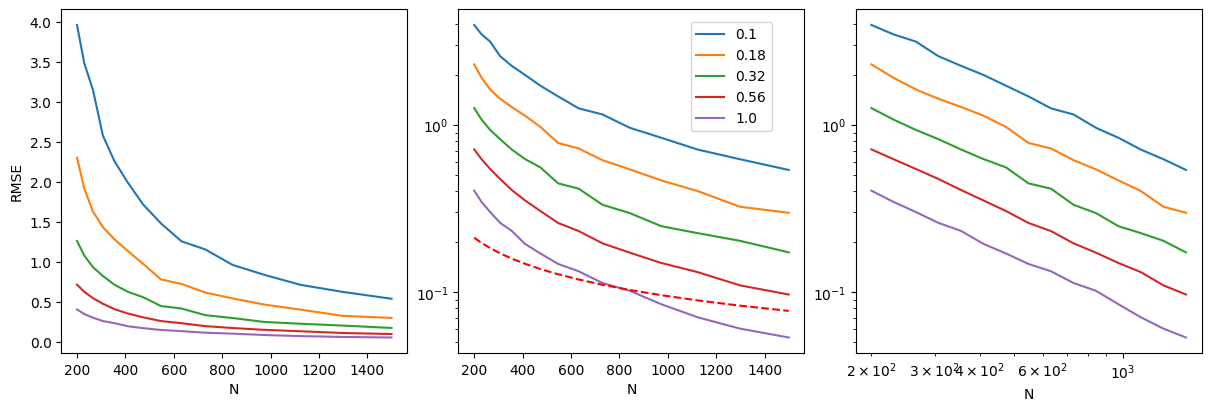

In [31]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=3, figsize=(12,4), layout='constrained')

axs[0].set_ylabel("RMSE")
axs[1].set_yscale("log")
axs[2].set_xscale("log")
axs[2].set_yscale("log")

for epsilon_sim, subhistory in agg_history.groupby("epsilon"):
    for ax in axs:
        subhistory.plot(x="N", y="gaussian error", label=epsilon_sim, ax=ax, legend=None)


se = np.std(educ) / np.sqrt(n_seq)
axs[1].plot(n_seq, se, linestyle='dashed', color="red")

_ = fig.legend(*axs[0].get_legend_handles_labels(), loc=(0.57, 0.68))
